# Imbalanced Learning Example

This notebook works through a real-life example (the Kaggle 'Give me some credit' dataset). For more information, see https://www.kaggle.com/c/GiveMeSomeCredit .

We'll be training linear classifiers on the data, including logistic regression, linear SVMs, and decision trees. The scikit-learn API provides a 'weights' option for these, and they're relatively fast to train.

In [1]:
# Import useful libraries used in the notebook
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

# Pull in the models we'll be building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Functions are defined in this module
from acm_imbalanced_library import *

# Visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Show plots inline 
%matplotlib inline

# Auto-reload external modules
%load_ext autoreload
%autoreload 2

## Data exploration

We'll clean up the CSV file after loading it by converting the columns to the appropriate types. Then we'll print out some summary statistics and pair-wise distributions to get a feel for the data.

In [2]:
# Read in the dataset, look at the column names and NAs
credit_df = pd.read_csv('cs-training.csv')
credit_df.head()


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
# Clean up the imported raw CSV file. Rename columns, fill in NA values,
# and change dependents to integer.
credit_df = cleanCreditDf(credit_df)

# Check how the data looks now
credit_df.head()

,ID,target,revolving_pct,age,past_due_30_59,debt_ratio,monthly_income,lines,past_due_gt_90,mortgages,past_due_60_89,dependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0


In [4]:
# Get some summary statistics from the dataframe
credit_df.describe()

,ID,target,revolving_pct,age,past_due_30_59,debt_ratio,monthly_income,lines,past_due_gt_90,mortgages,past_due_60_89,dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,5.348139e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.315206e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,1.550000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,4.357500e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


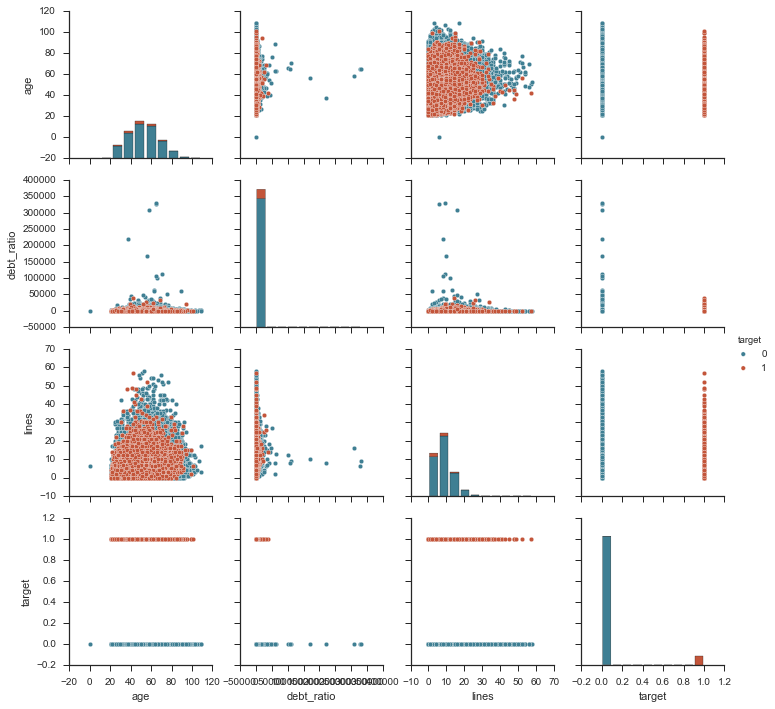

In [5]:
# Plot out the distributions to see what's going on, colour code by target
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(credit_df[['age', 'debt_ratio', 'lines', 'target']], 
                 hue='target', palette=sns.diverging_palette(220,20,n=2))


## Model training and evaluation

Now we've got an idea of the data structure, we can train some linear classifiers to check their relative performance. Before doing this, we'll need to remove:

* target - The model is supposed to tell use the target !
* ID - This is a unique identifier, and (should be) arbitrary is Kaggle have properly shuffled the dataset.

In [6]:
# Separate out the ID and target values from the dataset
X, y, id_val = removeIDTargetFromCreditDf(credit_df)


In [7]:
# Train a logistic regression model using the balanced class weights 

default_log_reg = LogisticRegression(class_weight=None)
balanced_log_reg = LogisticRegression(class_weight='balanced')

# Important to use a stratified K folds to make sure representative
# proportion of minority examples are used in each fold
cv = StratifiedKFold(y, n_folds=5, shuffle=True)

scores = cross_val_score(estimator=default_log_reg, X=X, y=y, cv=cv, scoring='accuracy')
def_log_reg_acc = np.mean(scores)

scores = cross_val_score(estimator=balanced_log_reg, X=X, y=y, cv=cv, scoring='accuracy')
bal_log_reg_acc = np.mean(scores)

scores = cross_val_score(estimator=default_log_reg, X=X, y=y, cv=cv, scoring='roc_auc')
def_log_reg_roc = np.mean(scores)

scores = cross_val_score(estimator=balanced_log_reg, X=X, y=y, cv=cv, scoring='roc_auc')
bal_log_reg_roc = np.mean(scores)

print 'Default logistic regression accuracy  = {:.6f}, AUC = {:.6f}'.format(def_log_reg_acc, def_log_reg_roc)
print 'Balanced logistic regression accuracy = {:.6f}, AUC = {:.6f}'.format(bal_log_reg_acc, bal_log_reg_roc)


Default logistic regression accuracy  = 0.933740, AUC = 0.696980
Balanced logistic regression accuracy = 0.783020, AUC = 0.790229


In [8]:
# Train a linear SVM model using the balanced class weights 

default_lin_svm = LinearSVC(class_weight=None)
balanced_lin_svm = LinearSVC(class_weight='balanced')

scores = cross_val_score(estimator=default_lin_svm, X=X, y=y, cv=cv,  scoring='roc_auc')
def_lin_svm_roc = np.mean(scores)

scores = cross_val_score(estimator=balanced_lin_svm, X=X, y=y, cv=cv, scoring='roc_auc')
bal_lin_svm_roc = np.mean(scores)

print 'Default linear SVM ROC = {:.6f}'.format(def_lin_svm_roc)
print 'Balanced linear SVM ROC = {:.6f}'.format(bal_lin_svm_roc)

Default linear SVM ROC = 0.547332
Balanced linear SVM ROC = 0.556079


In [9]:
# Train a Decision tree classifier

default_tree = DecisionTreeClassifier(class_weight=None)
balanced_tree = DecisionTreeClassifier(class_weight='balanced')

scores = cross_val_score(estimator=default_tree, X=X, y=y, cv=cv, scoring='roc_auc')
def_tree_roc = np.mean(scores)

scores = cross_val_score(estimator=balanced_tree, X=X, y=y, cv=cv, scoring='roc_auc')
bal_tree_roc = np.mean(scores)

print 'Default decision tree ROC = {:.6f}'.format(def_tree_roc)
print 'Balanced decision tree ROC = {:.6f}'.format(bal_tree_roc)

Default decision tree ROC = 0.611893
Balanced decision tree ROC = 0.601773


## Pre-processed datasets

R has a package designed to deal with imbalanced data, called 'unbalanced'. For more information see here: https://cran.r-project.org/web/packages/unbalanced/unbalanced.pdf.

The examples in the previous notebook are designed to be easy to read and modify, so they take a long time to process ~MBs of data. 

The R dataframes have a different order of columns, so a separate "clean" function is needed.

In [10]:
# Load in the R pre-processed dataframes, check AUC on each
print 'Loading R pre-processed dataframes'
credit_df_cnn = pd.read_csv('cs-training-CNN.csv')
credit_df_oss = pd.read_csv('cs-training-OSS.csv')
credit_df_smote = pd.read_csv('cs-training-smote.csv')
credit_df_tomek = pd.read_csv('cs-training-tomek.csv')

print 'Creating logistic regression setup'
bal_log_reg = LogisticRegression(class_weight='balanced')
# cv = StratifiedKFold(y, n_folds=5, shuffle=True)

eval_data = [credit_df_cnn, 
             credit_df_oss, 
             credit_df_smote, 
             credit_df_tomek]

eval_title = ['CNN', 'OSS', 'SMOTE', 'Tomek']

eval_results = {}

print 'Running evaluation of processed dataframes'
for data_idx, data in enumerate(eval_data):
    print '-> {} of {}'.format(data_idx+1, len(eval_data))
    data = cleanRProcessedCreditDf(data)
    X, y, id_val = removeIDTargetFromCreditDf(data)
    cv = StratifiedKFold(y, n_folds=5, shuffle=True)
    scores = cross_val_score(estimator=bal_log_reg, X=X, y=y, cv=cv, scoring='roc_auc')
    eval_results[eval_title[data_idx]] = np.mean(scores)
    
print 'Baseline logistic regression AUC = {:.6f}'.format(bal_log_reg_roc)


for result, value in eval_results.items():
    print '{} AUC = {:.6f}'.format(result, value)

Loading R pre-processed dataframes
Creating logistic regression setup
Running evaluation of processed dataframes
-> 1 of 4
-> 2 of 4
-> 3 of 4
-> 4 of 4
Baseline logistic regression AUC = 0.790229
CNN AUC = 0.817713
OSS AUC = 0.821785
Tomek AUC = 0.821941
SMOTE AUC = 0.909409


## Summary

In this notebook we evaluated some linear classifiers, noting:

* How their performance changes when optimizing for AUC instead of accuracy.
* How the weights can be used to improve ROC performance.
* Their performance on the Kaggle dataset.

After this, we loaded pre-processed datasets which were generated using the R 'unbalanced' package. See ```acm_imbalanced_dataset.R``` for more information. We then re-ran using the best performing linear classifier to check the AUC increase.

The best performing combination was Logistic Regression with balanced weights running on a SMOTE-processed dataset.

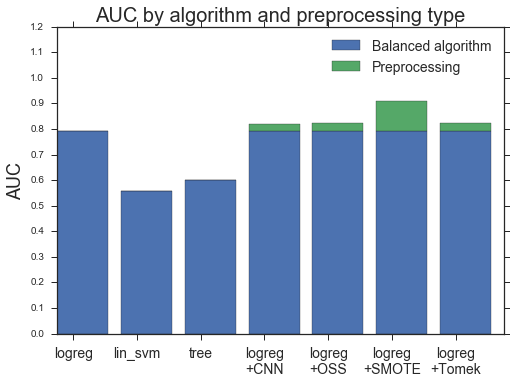

In [11]:
# Show a bar chart of the ROC results for each of the algorithms

ROC_labels = ['logreg', 'lin_svm', 'tree', 'logreg\n+CNN', 
            'logreg\n+OSS', 'logreg\n+SMOTE', 'logreg\n+Tomek']
ROC_vals = [bal_log_reg_roc, bal_lin_svm_roc, bal_tree_roc, 
            eval_results['CNN'], eval_results['OSS'], 
            eval_results['SMOTE'], eval_results['Tomek']]

width = 0.5
ind = np.arange(len(ROC_labels))
base_roc = [bal_log_reg_roc, bal_lin_svm_roc, bal_tree_roc, 
            bal_log_reg_roc, bal_log_reg_roc, 
            bal_log_reg_roc, bal_log_reg_roc]
inc_roc = [0,0,0, eval_results['CNN']-bal_log_reg_roc, 
           eval_results['OSS']-bal_log_reg_roc, 
            eval_results['SMOTE']-bal_log_reg_roc, 
           eval_results['Tomek']-bal_log_reg_roc]

p1 = plt.bar(ind, base_roc, color='b')
p2 = plt.bar(ind, inc_roc, color='g', bottom = base_roc)
plt.ylabel('AUC', fontsize=18)
plt.title('AUC by algorithm and preprocessing type', fontsize=20)
plt.xticks(ind + width/2, ROC_labels, fontsize=14)
plt.yticks(np.arange(0, 1.3, 0.1))
plt.legend((p1[0], p2[0]), ('Balanced algorithm', 'Preprocessing'), fontsize=14)
plt.show()
